In [311]:
import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# LASSO
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# OLS
import statsmodels.api as sm

# Neural Network
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#### Data Importing and Cleaning

In [312]:
# Import 'database.csv' as a dataframe
database_df = pd.read_csv('database.csv')
print(database_df.columns)

Index(['Date', 'DayOfWeek', 'AwakeData', 'AsleepData', 'Sleep Quality',
       'Meal Quality', 'Energy Level', 'Weather Qual.', 'Socialization',
       'Job Hours', 'Work Prod.', 'Chore Prod.', 'Work Out', 'Weight',
       'Go Outside', 'Shower', 'Caffeine', 'Partner Hours', 'Gaming Hours',
       'TV Hours', 'App Hours', 'Stress Level', 'Day Rating', 'EOD Emotion',
       'awakeCount', 'awakeDuration', 'awakeningsCount', 'duration',
       'efficiency', 'endTime', 'isMainSleep', 'logId', 'minuteData',
       'minutesAfterWakeup', 'minutesAsleep', 'minutesAwake',
       'minutesToFallAsleep', 'restlessCount', 'restlessDuration', 'startTime',
       'timeInBed'],
      dtype='object')


In [313]:
# List of columns deemed not useful for analysis
columns_to_drop = ['AwakeData', 'AsleepData', 'Weight', 'Go Outside', 'EOD Emotion', 'awakeCount', 'awakeDuration', 'duration', 
                   'endTime', 'isMainSleep', 'logId', 'minuteData', 'minutesAfterWakeup', 'minutesToFallAsleep']

# Drop the specified columns
cleaned_df = database_df.drop(columns=columns_to_drop)
cleaned_df.head()

,Date,DayOfWeek,Sleep Quality,Meal Quality,Energy Level,Weather Qual.,Socialization,Job Hours,Work Prod.,Chore Prod.,...,Stress Level,Day Rating,awakeningsCount,efficiency,minutesAsleep,minutesAwake,restlessCount,restlessDuration,startTime,timeInBed
0,2024-01-02,Tuesday,4.0,3.0,3.0,2.0,4.0,0.0,3.0,1.0,...,3.0,4.0,18.0,95.0,477.0,23.0,17.0,24.0,2024-01-02T00:46:00.000,502.0
1,2024-01-03,Wednesday,3.0,3.0,3.0,4.0,3.0,0.0,4.0,0.0,...,2.0,4.0,22.0,93.0,416.0,33.0,20.0,31.0,2024-01-03T00:32:00.000,449.0
2,2024-01-04,Thursday,3.0,3.0,3.0,3.0,3.0,0.0,3.0,2.0,...,2.0,4.0,21.0,94.0,486.0,33.0,21.0,33.0,2024-01-03T23:35:30.000,519.0
3,2024-01-05,Friday,3.0,2.0,2.0,3.0,1.0,0.0,3.0,2.0,...,2.0,3.0,22.0,92.0,448.0,40.0,21.0,39.0,2024-01-04T23:52:30.000,488.0
4,2024-01-06,Saturday,4.0,3.0,3.0,2.0,2.0,0.0,3.0,1.0,...,2.0,3.0,22.0,93.0,454.0,36.0,19.0,28.0,2024-01-05T23:56:30.000,490.0


#### Creating a 'totalScreenTime' Column 

In [314]:
# Adding together all screen time columns
cleaned_df['totalScreenTime'] = cleaned_df['Gaming Hours'] + cleaned_df['TV Hours'] + cleaned_df['App Hours']
cleaned_df['totalScreenTime']

0      4.0
1      1.0
2      4.0
3      5.0
4      5.0
      ... 
106    6.0
107    5.0
108    8.0
109    NaN
110    NaN
Name: totalScreenTime, Length: 111, dtype: float64

#### Creating a 'totalProductivity' Column

In [315]:
# Adding together all productivity columns
cleaned_df['totalProductivity'] = cleaned_df['Job Hours'] + cleaned_df['Work Prod.'] + cleaned_df['Chore Prod.']
cleaned_df['totalProductivity']

0      4.0
1      4.0
2      5.0
3      5.0
4      4.0
      ... 
106    7.0
107    5.0
108    6.0
109    NaN
110    NaN
Name: totalProductivity, Length: 111, dtype: float64

#### Creating a 'minutesAfterMidnight' Column to Represent a Bedtime

In [316]:
# Convert 'startTime' column to datetime format
cleaned_df['startTime'] = pd.to_datetime(cleaned_df['startTime'])

# Extract the hour and minute components from 'startTime'
hour = cleaned_df['startTime'].dt.hour
minute = cleaned_df['startTime'].dt.minute

# Calculate the total minutes after midnight
cleaned_df['minutesAfterMidnight'] = hour * 60 + minute

# For times before midnight, subtract the total minutes in a day
cleaned_df.loc[cleaned_df['minutesAfterMidnight'] >= 720, 'minutesAfterMidnight'] -= 1440

# Drop the 'startTime' column
cleaned_df = cleaned_df.drop(columns=['startTime'])
cleaned_df['minutesAfterMidnight']

0      46.0
1      32.0
2     -25.0
3      -8.0
4      -4.0
       ... 
106    53.0
107     NaN
108    75.0
109    14.0
110    60.0
Name: minutesAfterMidnight, Length: 111, dtype: float64

#### Converting the Day of the Week to an Integer

In [317]:
# Define a mapping from day names to integers
day_mapping = {
    'Sunday': 0,
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6
}

# Convert 'DayOfWeek' to integers
cleaned_df['DayOfWeek'] = cleaned_df['DayOfWeek'].map(day_mapping)

#### Plotting 'Day Rating' by Day of the Week

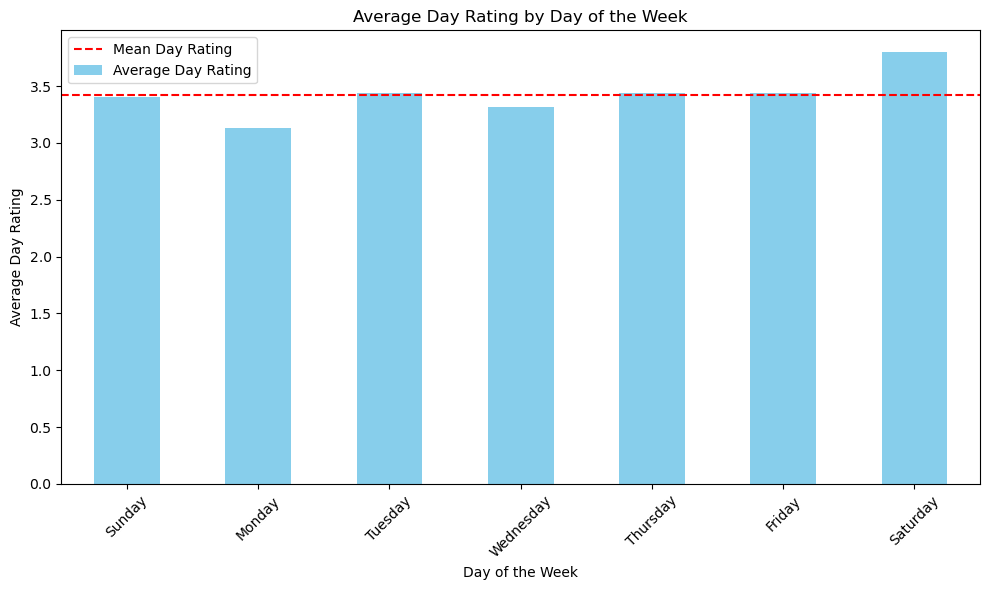

In [318]:
# Extract 'Day Rating' and 'DayOfWeek' columns
day_rating_by_dayofweek = cleaned_df[['Day Rating', 'DayOfWeek']]

# Calculate average 'Day Rating' for each day of the week
average_day_rating = day_rating_by_dayofweek.groupby('DayOfWeek')['Day Rating'].mean()

# Define the order of the days of the week
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Calculate the mean 'Day Rating'
mean_day_rating = cleaned_df['Day Rating'].mean()

# Plot 'Day Rating' by 'DayOfWeek'
plt.figure(figsize=(10, 6))
average_day_rating.plot(kind='bar', color='skyblue', label='Average Day Rating')
plt.axhline(y=mean_day_rating, color='red', linestyle='--', label='Mean Day Rating')
plt.title('Average Day Rating by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Day Rating')

# Change x-axis labels to day names
plt.xticks(range(7), [day_order[i] for i in range(7)], rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

#### Plotting all Day Ratings

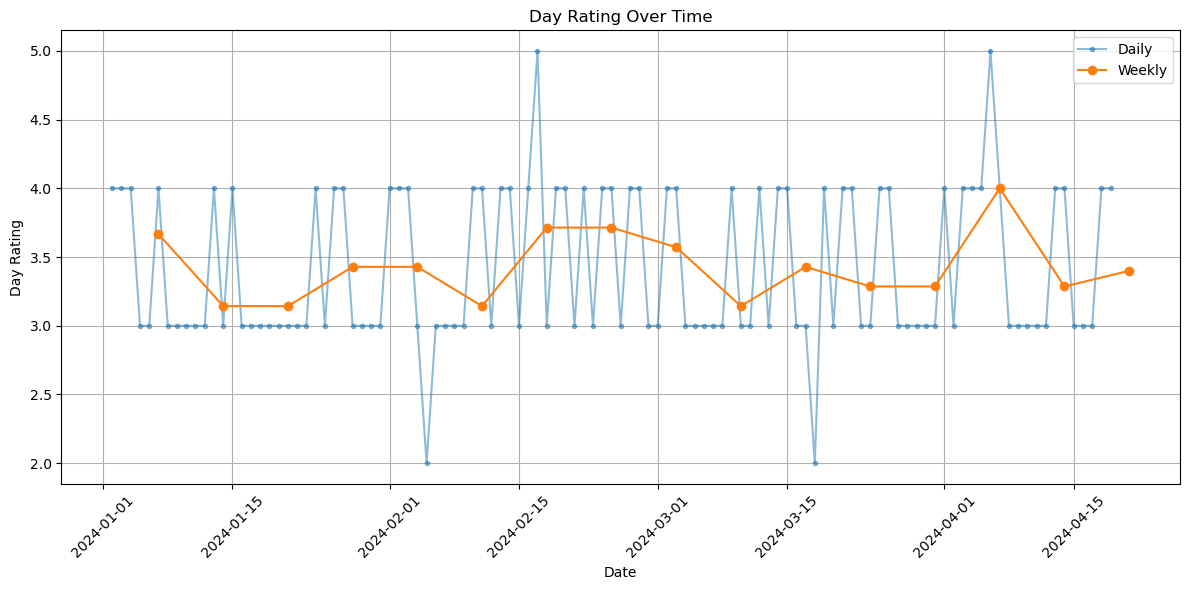

In [319]:
# Convert 'Date' column to datetime format
cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date'])

# Aggregate the data by day and calculate the mean 'Day Rating' for each day
daily_data = cleaned_df.resample('D', on='Date').mean()

# Aggregate the data by week and calculate the mean 'Day Rating' for each week
weekly_data = cleaned_df.resample('W', on='Date').mean()

# Plot the smoothed lines
plt.figure(figsize=(12, 6))

# Plot daily data
plt.plot(daily_data.index, daily_data['Day Rating'], marker='.', linestyle='-', label='Daily', alpha=0.5)

# Plot weekly data
plt.plot(weekly_data.index, weekly_data['Day Rating'], marker='o', linestyle='-', label='Weekly')

plt.title('Day Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Day Rating')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Calcuating All Correlations

                      DayOfWeek  Sleep Quality  Meal Quality  Energy Level  \
DayOfWeek              1.000000       0.099257     -0.142942      0.065234   
Sleep Quality          0.099257       1.000000     -0.172529      0.537585   
Meal Quality          -0.142942      -0.172529      1.000000      0.045188   
Energy Level           0.065234       0.537585      0.045188      1.000000   
Weather Qual.          0.023556       0.084492     -0.087603      0.128206   
Socialization         -0.052824      -0.111899      0.068316      0.039267   
Job Hours             -0.095400      -0.184724      0.076740     -0.012787   
Work Prod.            -0.118035      -0.127201      0.174465      0.082772   
Chore Prod.            0.173482       0.145540     -0.071903      0.060531   
Work Out               0.103510       0.110882      0.065298     -0.007659   
Shower                -0.028565      -0.140656      0.087301     -0.145159   
Caffeine              -0.052917      -0.317238      0.021977    

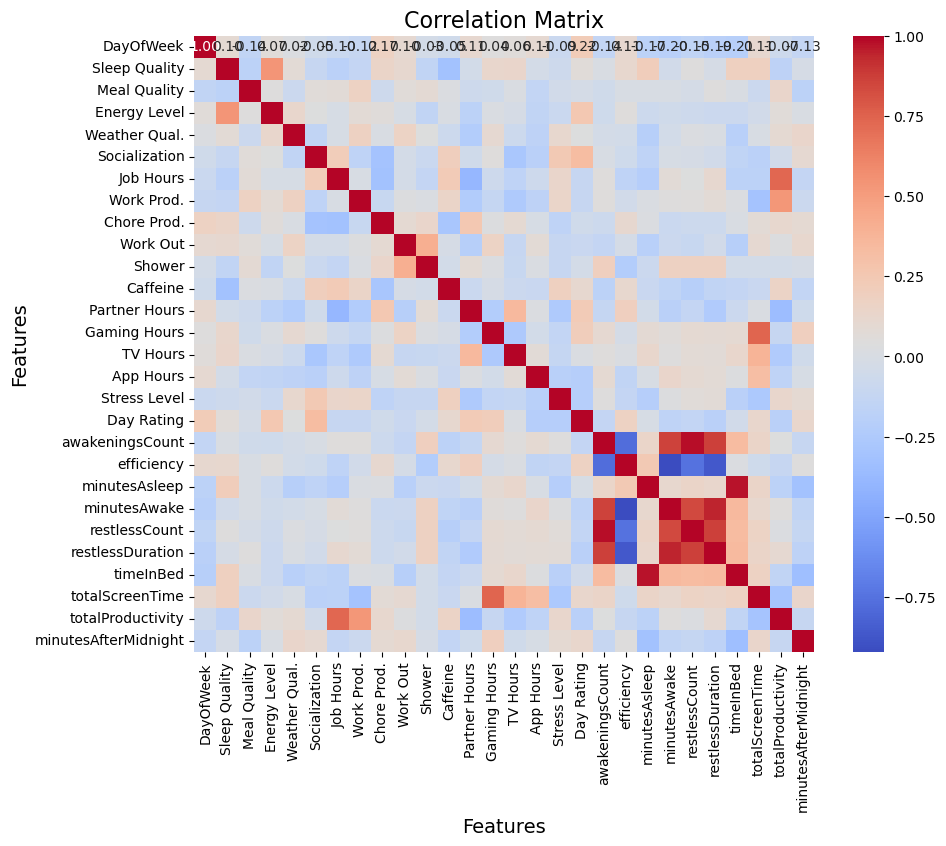

In [320]:
# Define columns to drop
columns_to_drop = ['Date']

# Drop the specified columns
cor_cleaned_df = cleaned_df.drop(columns=columns_to_drop)

# Calculate the correlation matrix
correlation_matrix = cor_cleaned_df.corr()
print(correlation_matrix)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.show()

#### Calculating Statistically Significant Feature Pairs

In [321]:
# Define significance level
alpha = 0.05

# Drop rows with NaN values
cleaned_df.dropna(inplace=True)

# Initialize a list to store statistically significant feature pairs
significant_pairs = []

# Iterate through each pair of features in the correlation matrix
total_pairs = len(correlation_matrix.columns) ** 2
significant_count = 0

for feature1 in correlation_matrix.columns:
    for feature2 in correlation_matrix.columns:
        if feature1 != feature2:  # Exclude self-correlation
            # Calculate Pearson correlation coefficient and p-value
            correlation_coefficient = correlation_matrix.loc[feature1, feature2]
            p_value = pearsonr(cleaned_df[feature1], cleaned_df[feature2])[1]
            # Check if the p-value is less than the significance level
            if p_value < alpha:
                significant_pairs.append((feature1, feature2, correlation_coefficient, p_value))
                significant_count += 1

# Create DataFrame of statistically significant feature pairs
significant_pairs_df = pd.DataFrame(significant_pairs, columns=['Feature 1', 'Feature 2', 'Correlation', 'P-value'])

# Sort DataFrame by the absolute value of correlation coefficients
significant_pairs_sorted = significant_pairs_df.reindex(significant_pairs_df['Correlation'].abs().sort_values(ascending=False).index)

# Display the sorted DataFrame
significant_pairs_sorted.head(50)

,Feature 1,Feature 2,Correlation,P-value
72,awakeningsCount,restlessCount,0.981730,4.516497e-68
93,restlessCount,awakeningsCount,0.981730,4.516497e-68
106,timeInBed,minutesAsleep,0.971968,1.226892e-58
84,minutesAsleep,timeInBed,0.971968,1.226892e-58
90,minutesAwake,restlessDuration,0.940379,7.239163e-44
101,restlessDuration,minutesAwake,0.940379,7.239163e-44
78,efficiency,minutesAwake,-0.920927,2.002701e-38
88,minutesAwake,efficiency,-0.920927,2.002701e-38
96,restlessCount,restlessDuration,0.871628,1.394961e-32
102,restlessDuration,restlessCount,0.871628,1.394961e-32


#### Feature Selection using LASSO

In [322]:
# Dropping 'Date' from our dataset
cleaned_df = cleaned_df.drop('Date', axis=1)

# Extract features and target variable
X = cleaned_df.drop('Day Rating', axis=1)
y = cleaned_df['Day Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize LASSO model
lasso = Lasso(alpha=0.1)

# Fit the model
lasso.fit(X_train_scaled, y_train)

# Print the coefficients
print("LASSO Coefficients:")
for feature, coef in zip(X.columns, lasso.coef_):
    print(f"{feature}: {coef}")

LASSO Coefficients:
DayOfWeek: 0.01720510884063615
Sleep Quality: -0.0
Meal Quality: 0.0
Energy Level: 0.04033101391069694
Weather Qual.: 0.0
Socialization: 0.07992958897926698
Job Hours: -0.0
Work Prod.: -0.0
Chore Prod.: -0.0
Work Out: -0.0
Shower: -0.0
Caffeine: 0.0
Partner Hours: 0.019454202521196232
Gaming Hours: 0.0
TV Hours: 0.0
App Hours: -0.0
Stress Level: -0.05201983639506906
awakeningsCount: -0.0
efficiency: 0.0
minutesAsleep: -0.0
minutesAwake: -0.0
restlessCount: -0.0
restlessDuration: -0.0
timeInBed: -0.0
totalScreenTime: 0.0
totalProductivity: -0.00047543094045387883
minutesAfterMidnight: 0.03735943768527726


#### Running OLS Regression Model

In [323]:
# Use selected features
selected_features = X.columns[lasso.coef_ != 0]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Extract features and target variable
X_lasso = cleaned_df.drop('Day Rating', axis=1)
y_lasso = cleaned_df['Day Rating']

# Extract selected features based on LASSO coefficients
selected_features_lasso = X_lasso.columns[lasso.coef_ != 0]
X_ols = X_lasso[selected_features_lasso]

# Add constant term to the features (bias term)
X_ols = sm.add_constant(X_ols)

# Fit OLS regression model
ols_model = sm.OLS(y_lasso, X_ols).fit()

# Print summary of the model
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             Day Rating   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     6.782
Date:                Sun, 21 Apr 2024   Prob (F-statistic):           2.23e-06
Time:                        21:29:12   Log-Likelihood:                -54.277
No. Observations:                  92   AIC:                             124.6
Df Residuals:                      84   BIC:                             144.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.5607 

#### Defining Variables for the NN

In [324]:
# Drop any columns with NaN values
cleaned_df_numeric = cleaned_df_numeric.dropna(axis=1)

# Extract features and target variable
X_lasso = cleaned_df_numeric.drop('Day Rating', axis=1)
y_lasso = cleaned_df_numeric['Day Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_lasso, y_lasso, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)  # convert Series to numpy array
y_test = torch.tensor(y_test.values, dtype=torch.float32)    # convert Series to numpy array

#### Building the Deep Neural Network (DNN)

In [327]:
class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(DeepNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # input layer
        self.fc2 = nn.Linear(128, 64)          # hidden layer with 64 units
        self.fc3 = nn.Linear(64, 32)           # hidden layer with 32 units
        self.fc4 = nn.Linear(32, 16)           # hidden layer with 16 units
        self.fc5 = nn.Linear(16, 1)            # output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Initialize the deep neural network model
input_size = X_train.shape[1]
model = DeepNeuralNetwork(input_size)

# Initialize the early stopping object
early_stopping = EarlyStopping(patience=10, min_delta=0.001)

# Lower the learning rate
optimizer = optim.Adam(model.parameters(), lr=0.000025)

num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % (num_epochs/10) == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Validate on test set
    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test.view(-1, 1))

        # Check for early stopping
        if early_stopping(test_loss):
            print("Early stopping")
            break

if early_stopping.early_stop:
    print("Stopped training due to early stopping")
else:
    print("Training completed without early stopping")

# Print final test loss
print(f'Final Test Loss: {test_loss.item():.4f}\n')

Epoch [1000/10000], Loss: 0.4883
Epoch [2000/10000], Loss: 0.1580
Epoch [3000/10000], Loss: 0.0520
Epoch [4000/10000], Loss: 0.0111
Epoch [5000/10000], Loss: 0.0012
Epoch [6000/10000], Loss: 0.0000
Epoch [7000/10000], Loss: 0.0000
Epoch [8000/10000], Loss: 0.0000
Epoch [9000/10000], Loss: 0.0000
Epoch [10000/10000], Loss: 0.0000
Stopped training due to early stopping
Final Test Loss: 0.5328



#### Printing the DNN Features and Respective Weights

In [326]:
# Print weights after training along with selected feature names
print("Feature Weights:")
for name, param in model.named_parameters():
    if 'weight' in name:
        print(f"{name}:")
        for feature_name, weight in zip(selected_features, param.data):
            print(f"{feature_name}: {weight}")

Feature Weights:
fc1.weight:
DayOfWeek: tensor([-0.1497, -0.1139, -0.0753,  0.2282,  0.0683,  0.1512, -0.1027, -0.1029,
        -0.2367,  0.1057,  0.0068,  0.1483, -0.1888, -0.1124, -0.1521, -0.1264,
         0.0434, -0.1196, -0.0049,  0.1030, -0.1274,  0.0814,  0.0840, -0.0540,
         0.0284, -0.0557, -0.1319])
Energy Level: tensor([ 0.1835, -0.0651,  0.0765,  0.1111, -0.1660,  0.2179, -0.0378, -0.1631,
        -0.0882, -0.1615,  0.0513, -0.2073,  0.1638,  0.1584, -0.2331,  0.1130,
         0.0259,  0.1643, -0.1264, -0.1812, -0.1241,  0.1514, -0.1279,  0.1583,
         0.1348,  0.0336, -0.1112])
Socialization: tensor([-0.2367, -0.1436,  0.1234, -0.1317, -0.0035, -0.1916, -0.1522, -0.0846,
        -0.1449,  0.0543,  0.1068, -0.1926,  0.0268,  0.1674,  0.0814,  0.1265,
        -0.2111,  0.0148,  0.0271, -0.0315,  0.1281,  0.0490, -0.0514,  0.1349,
         0.1043, -0.1710,  0.1764])
Partner Hours: tensor([ 0.1807,  0.1753,  0.0064,  0.1486, -0.1590, -0.1768,  0.1729, -0.0520,
        